# **Impact of the 2020 Midwest Derecho on Vegetation Health in Backbone State Park, Iowa**

# Introduction
### Background Info
- Backbone State Park, established in 1920 as Iowa's first state park, is a geographically unique location renowned for its natural beauty [1]. 
- On August 10, 2020, a powerful derecho struck the Midwest, killing 4 people and causing billions in damage [2].
    - A "derecho" is a fast-moving band of storms that produce destructive winds and even tornadoes [3].
### Question
How did the 2020 Midwest derecho impact vegetation health inside Backbone State Park?
### Methodology
- To answer this, I plotted NDVI values across the park from shortly before the derecho, shortly after, and the difference from before to after. I used the Microsoft Planetary Computer STAC API to gather Landsat 8 satellite data, which i then computed NDVI from.

# Step 0: Import Libraries

In [1]:
# --- 1. Core Geospatial and Vector Data ---
import osmnx as ox            # For initial park geocoding (GeoDataFrame creation)
import geopandas as gpd         # For handling GeoDataFrames (the park boundary)

# --- 2. Cloud Imagery Access (STAC) ---
from pystac_client import Client  # For searching the STAC catalog
import planetary_computer as pc  # For signing STAC assets (access permissions)
from odc.stac import stac_load    # For loading the STAC items into Xarray objects

# --- 3. Raster Processing and Analysis ---
import numpy as np              # For array manipulation (used implicitly in NDVI formula)
import xarray as xr             # For managing labeled, multi-dimensional satellite data
import rioxarray as rxr         # For georeferencing, clipping, and re-projection (key for NDVI array handling)

# --- 4. Visualization & Parallel Processing ---
import matplotlib.pyplot as plt # For generating the final NDVI plots
from dask.distributed import Client as DaskClient # For speeding up cloud data processing

# Step 1: Get Backbone State Park Boundary
In the following cell, we use the osmnx package to define our area (Backbone State Park) of interest as a geodataframe:

0    POLYGON ((-91.57272 42.61489, -91.56783 42.614...
Name: geometry, dtype: geometry


<Axes: >

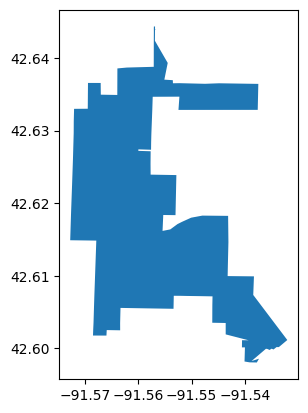

In [2]:
# geocode to a polygon GeoDataFrame via OSM
bsp_gdf = ox.geocode_to_gdf("Backbone State Park, Delaware County, Iowa, USA")

# If geocode_to_gdf returns multiple matches, filter by name
bsp_gdf = bsp_gdf[bsp_gdf['display_name'].str.contains("Backbone State Park", case=False, na=False)]

print(bsp_gdf.geometry)
bsp_gdf.to_file("backbone_state_park_boundary.geojson", driver="GeoJSON")
bsp_gdf.plot()

# Step 2: Define STAC Query Parameters + Search Landsat Catalog
- STAC (SpatioTemporal Asset Catalog) is a framework that allows spatial data (Landsat 8 imagery, in this case) to be cataloged and organized in a uniform way, making them easily searchable across different platforms [4].
- In the following code cell, we connect to the Microsoft Planetary Computer STAC API, which hosts the Landsat 8 Collection 2 Level 2 (L2) data we are using (which NDVI is derived from).
- We search for data with two constraints:
    - Temporal:
        - August 1-9 (just before the storm)
        - August 10-15 (just after the storm)
    - Spatial: makes it so the search only yields scenes that overlap with the bounds of the park (the area boxed by the north, south, east, and west limits of the park gdf, which we plotted in the previous step)
- We look at the cloud cover for each item found in the search to decide which scenes to use for our before-and-after comparison.

In [3]:
# Set the Microsoft Planetary Computer STAC endpoint
STAC_API_URL = "https://planetarycomputer.microsoft.com/api/stac/v1"
catalog = Client.open(STAC_API_URL, modifier=pc.sign_inplace)
bbox = bsp_gdf.total_bounds.tolist()

# --- Pre-Derecho Search ---
search_pre = catalog.search(
    collections=["landsat-8-c2-l2"],
    bbox=bbox,
    datetime="2020-08-01/2020-08-09",
)
items_pre = search_pre.get_all_items()

# --- Post-Derecho Search ---
search_post = catalog.search(
    collections=["landsat-8-c2-l2"],
    bbox=bbox,
    datetime="2020-08-10/2020-08-15",
)
items_post = search_post.get_all_items()

# Output Pre-Derecho Items
print(f"Found {len(items_pre)} pre-derecho items:")
for i, item in enumerate(items_pre):
    date = item.datetime.strftime('%Y-%m-%d')
    # Get the cloud cover property, which is crucial for selection
    cloud_cover = item.properties.get('eo:cloud_cover', 'N/A')
    print(f"- Item {i+1}: Acquisition Date: {date}, Cloud Cover: {cloud_cover:.1f}%")

# Output Post-Derecho Items
print(f"\nFound {len(items_post)} post-derecho items:")
for i, item in enumerate(items_post):
    date = item.datetime.strftime('%Y-%m-%d')
    cloud_cover = item.properties.get('eo:cloud_cover', 'N/A')
    print(f"- Item {i+1}: Acquisition Date: {date}, Cloud Cover: {cloud_cover:.1f}%")

c:\Users\elism\miniconda3\Lib\site-packages\pystac_client\item_search.py:896: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(


Found 2 pre-derecho items:
- Item 1: Acquisition Date: 2020-08-04, Cloud Cover: 26.4%
- Item 2: Acquisition Date: 2020-08-04, Cloud Cover: 33.6%

Found 1 post-derecho items:
- Item 1: Acquisition Date: 2020-08-11, Cloud Cover: 0.0%


We will use Item 1 from the pre-derecho query as our pre-derecho scene, as it has a lower cloud cover (26.4%) than Item 2 (33.6%).

# Step 3: Load the Data as Xarray Datasets
In this next block, we use the stac_load function (from the odc.stac package) to load the data for our selected pre-derecho (8/4) and post-derecho (8/11) scenes.
- We create an Xarray dataset for each scene by loading bands 4 ("red") and 5 ("nir08"), which we will use to compute NDVI, over the previously defined bbox region.

In [4]:
# Select the single best (least cloudy) item for each period
# Since there are 2 pre-derecho items, items_pre[0] will select the best one.
item_pre = items_pre[0] 
item_post = items_post[0] # This selects the item at index 0 (Item 1)

# List the required Landsat 8 bands (red and nir08 for NDVI)
landsat_bands = ["red", "nir08"] 

# Load the Pre-Derecho data
data_pre = stac_load(
    [item_pre],
    bands=landsat_bands,
    chunks=None, # Load as Dask array for lazy computation
    geometries=bsp_gdf.geometry,
)

# Load the Post-Derecho data
data_post = stac_load(
    [item_post],
    bands=landsat_bands,
    chunks=None,
    geometries=bsp_gdf.geometry,
)

# Step 4: Calculate NDVI
The process to calculate NDVI comes in 2 steps: 
- **Calibrate data / convert to surface reflectance:** The raw Landsat data in the datasets must be converted to surface reflectance values using the scaling factor of 0.0000275 - 0.2 as officially defined by USGS for Landsat Collection 2 [5].  
- **Apply NDVI formula:** We compute NDVI from the scaled surface reflectance values using the following formula:$$\text{NDVI} = \frac{\text{NIR} - \text{RED}}{\text{NIR} + \text{RED}} = \frac{\text{Band 5} - \text{Band 4}}{\text{Band 5} + \text{Band 4}} = \frac{\text{nir08} - \text{red}}{\text{nir08} + \text{red}}$$ [6].
The following cell creates two raster datasets, one with the NDVI values pre-derecho and the other post-derecho.

In [5]:
# Define Landsat 8 Collection 2 Level 2 Scaling Factors for Surface Reflectance
MULT_FACTOR = 0.0000275
ADD_OFFSET = -0.2

# --- Pre-Derecho NDVI Calculation (Landsat 8) ---
data_pre_reflectance = data_pre.astype('float32') * MULT_FACTOR + ADD_OFFSET
nir_pre = data_pre_reflectance["nir08"].squeeze()
red_pre = data_pre_reflectance["red"].squeeze()
ndvi_pre = ((nir_pre - red_pre) / (nir_pre + red_pre)).compute() 
ndvi_pre.name = "NDVI Pre-Derecho"

# FIX: Define the projected GDF variable using the NDVI data's CRS
bsp_gdf_proj_pre = bsp_gdf.to_crs(ndvi_pre.rio.crs) 

# Clip the array using the projected bounds
ndvi_pre = ndvi_pre.rio.clip_box(*bsp_gdf_proj_pre.total_bounds)

# --- Post-Derecho NDVI Calculation (Landsat 8) ---
data_post_reflectance = data_post.astype('float32') * MULT_FACTOR + ADD_OFFSET
nir_post = data_post_reflectance["nir08"].squeeze()
red_post = data_post_reflectance["red"].squeeze()
ndvi_post = ((nir_post - red_post) / (nir_post + red_post)).compute()
ndvi_post.name = "NDVI Post-Derecho"

# FIX: Define the projected GDF variable using the NDVI data's CRS
bsp_gdf_proj_post = bsp_gdf.to_crs(ndvi_post.rio.crs)

# Clip the array using the projected bounds
ndvi_post = ndvi_post.rio.clip_box(*bsp_gdf_proj_post.total_bounds)

# --- Re-project the NDVI data for plotting in Lat/Lon ---
# The original data (ndvi_pre, ndvi_post) remains in UTM (metres)
# for calculation accuracy, but we create new variables for plotting.
ndvi_pre_deg = ndvi_pre.rio.reproject("EPSG:4326")
ndvi_post_deg = ndvi_post.rio.reproject("EPSG:4326")

# Re-project the boundary as well for the overlay plot
bsp_gdf_deg = bsp_gdf.to_crs("EPSG:4326") 

# Step 5: Create pre-derecho and post-derecho plots
We are finally ready to plot the NDVI for our pre-derecho and post-derecho scenes.

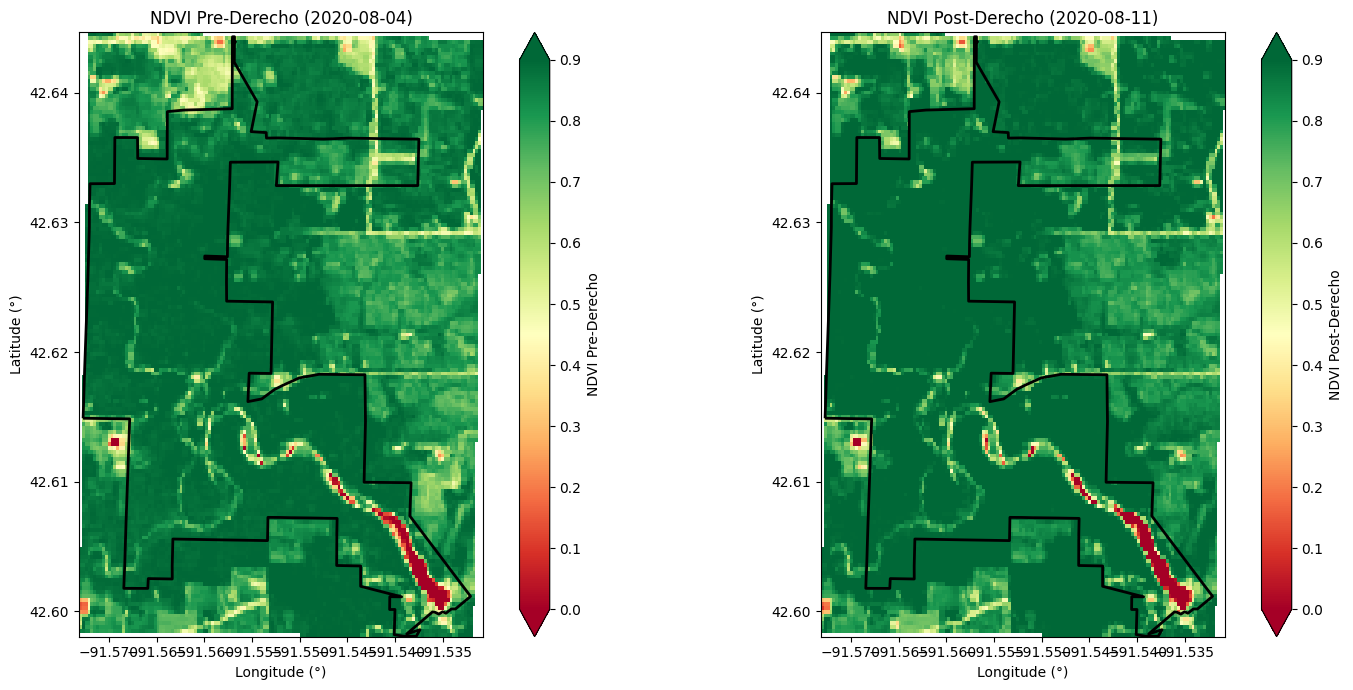

In [6]:
# --- Plotting ---
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# 1. Plot Pre-Derecho NDVI (using the re-projected data)
ndvi_pre_deg.plot.imshow(ax=axes[0], cmap='RdYlGn', vmin=0, vmax=0.9, extend='both')
axes[0].set_title(f"NDVI Pre-Derecho ({item_pre.datetime.strftime('%Y-%m-%d')})")
# Plot the re-projected park boundary
bsp_gdf_deg.boundary.plot(ax=axes[0], color='black', linewidth=2) 
# Set axes labels explicitly
axes[0].set_xlabel("Longitude (°)")
axes[0].set_ylabel("Latitude (°)")


# 2. Plot Post-Derecho NDVI (using the re-projected data)
ndvi_post_deg.plot.imshow(ax=axes[1], cmap='RdYlGn', vmin=0, vmax=0.9, extend='both')
axes[1].set_title(f"NDVI Post-Derecho ({item_post.datetime.strftime('%Y-%m-%d')})")
# Plot the re-projected park boundary
bsp_gdf_deg.boundary.plot(ax=axes[1], color='black', linewidth=2)
# Set axes labels explicitly
axes[1].set_xlabel("Longitude (°)")
axes[1].set_ylabel("Latitude (°)")


plt.tight_layout()
plt.show()

# Step 6: Plot the difference

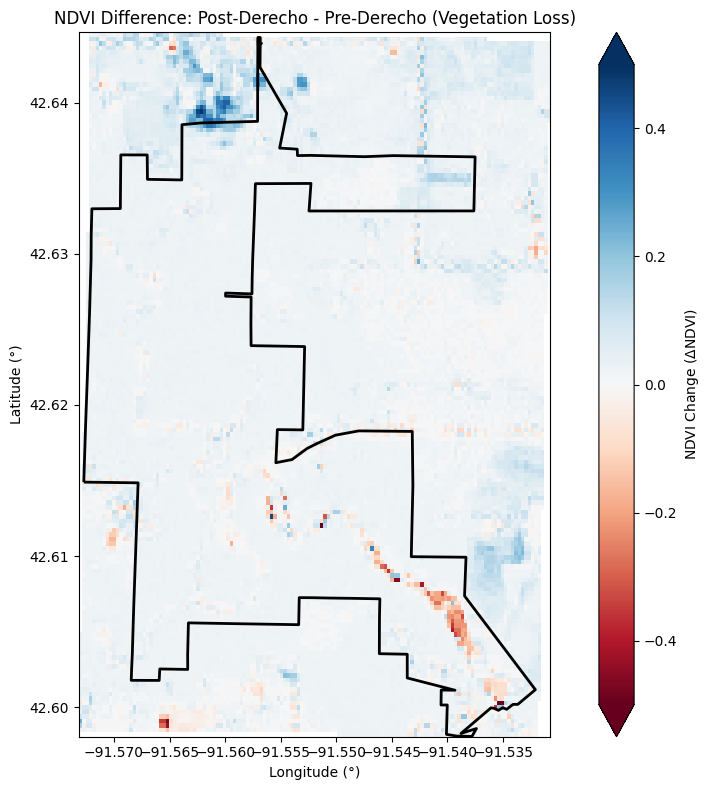

In [7]:
# 1. CALCULATE DIFFERENCE (Use the original UTM data for maximum accuracy)
# Difference = Post-Derecho NDVI - Pre-Derecho NDVI
# Negative values will represent a drop in vegetation health/canopy loss.
ndvi_diff = ndvi_post - ndvi_pre
ndvi_diff.name = "NDVI_Difference"

# 2. REPROJECT FOR PLOTTING (Convert the difference array to Lat/Lon)
ndvi_diff_deg = ndvi_diff.rio.reproject("EPSG:4326")

# 3. PLOT THE DIFFERENCE
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Use a diverging colormap (RdBu) centered on zero (white)
# We set vmin/vmax symmetrically to clearly show loss vs. minor gain
im = ndvi_diff_deg.plot.imshow(
    ax=ax,
    cmap='RdBu', # Red/Blue diverging map (Red=Gain, Blue=Loss)
    vmin=-0.5,   # Symmetric range focuses on significant changes
    vmax=0.5,
    extend='both',
    cbar_kwargs={'label': r'NDVI Change ($\Delta$NDVI)'}
)

# Plot the re-projected park boundary for context
bsp_gdf_deg.boundary.plot(ax=ax, color='black', linewidth=2) 

# Set title and labels
ax.set_title("NDVI Difference: Post-Derecho - Pre-Derecho (Vegetation Loss)")
ax.set_xlabel("Longitude (°)")
ax.set_ylabel("Latitude (°)")

plt.tight_layout()
plt.savefig("ndvi_difference_plot.png")

This plot suggests that the 2020 Midwest derecho did not have a significant impact on vegetation health in Backbone State Park, except for possibly a small region in the southeast corner.

# Works Cited
1. https://www.iowadnr.gov/places-go/state-parks/all-parks/backbone-state-park
2. https://www.climate.gov/disasters2020
3. https://www.nesdis.noaa.gov/about/k-12-education/severe-weather/what-derecho
4. https://pro.arcgis.com/en/pro-app/latest/help/data/imagery/introduction-to-stac.htm
5. https://www.usgs.gov/landsat-missions/landsat-collection-2-level-2-science-products
6. https://www.usgs.gov/landsat-missions/landsat-normalized-difference-vegetation-index
